## Principal Components

- Widely used feature extraction method for analysis and visualization
- Orthonormal basis functions 
- Require good data engineering as a precursor to their use

In [127]:


# Data processing and functions
import pandas as pd
import numpy as np
import scipy as sp

# Analytics and modeling
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import manifold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import statsmodels.sandbox.tools.tools_pca as sm_pca
from statsmodels.formula.api import ols as sm_ols
from statsmodels.stats.anova import anova_lm as sm_anova
from patsy.contrasts import Treatment
from patsy import dmatrices

# Graphing and visualizing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from pylab import savefig

# Setting graphing preferences
sns.set(style="darkgrid", color_codes=True)

# Printing
import locale

# Show plots locally
locale.setlocale( locale.LC_ALL, '' )

%matplotlib inline

### In-Class Exercise 1
### Community Crime Data: Load the data


- Load the community crime data: CommunityCrimeDataRaw.txt
- The data do not have a header row, this is in a separate file: CrimeVariableLabels.txt
- Read crime.description.txt to determine the missing value character

### In-Class Exercise 1 Answers
### Community Crime Data: Load the data


- I have loaded the community crime data below
- I bring in the header information separately and append it as the columns
- The missing value character is '?', which I use as part of the read_csv process

In [5]:
# Load our data
path = "/Users/mead/Fall2017/DonBrown-DS6001/FeatureEngineering/"

file = "CommunityCrimeDataRaw.txt"

label = "CrimeVariableLabels.txt"
# DATA
crime_df = pd.read_csv(path + file, low_memory = False, header = None, na_values = '?')
# COLUMN HEADER
label_df = pd.read_csv(path + label, header=None)

In [6]:
# Add in columns
crime_df.columns = label_df.loc[:,0]

In [7]:
# First few rows
crime_df.head(3)

,communityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,1,11980,3.10,1.37,91.78,6.50,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,1,23123,2.82,0.80,95.57,3.44,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51


## In-Class Exercise 2  - Data Cleaning

- Remove the non-predictor/response variables (see 
http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized )

- Remove variables with more that 1k missing values
- Impute the remainder of the missing values

## In-Class Exercise 2  - Data Cleaning Answers

- We successfully remove the non-predictor/response columns which are shown below ('communityname', 'state', 'countyCode', 'communityCode')
- Remove variables with more that 1k missing values done below
- Impute the remainder of the missing values done below using the DataFrameImputer class we made
- I also saved the cleaned output to a csv: CrimeDataClean.csv

In [16]:
# According to the website, these are non-predictor/response variables
crime_df.iloc[:,:4].columns

Index([u'communityname', u'state', u'countyCode', u'communityCode'], dtype='object', name=0)

In [17]:
# Make a clean version of crimes with non-predictor/response variables removed
crime_df_clean = crime_df.iloc[:,5:]
print(crime_df_clean.shape)
# Look at the missing values by column
print("Here are the missing values by column: \n" + str(crime_df_clean.isnull().sum()))
print("And that's a total of " + str(crime_df_clean.isnull().sum().sum()) + " missing values across all columns")

(2215, 142)
Here are the missing values by column: 
0
population                0
householdsize             0
racepctblack              0
racePctWhite              0
racePctAsian              0
racePctHisp               0
agePct12t21               0
agePct12t29               0
agePct16t24               0
agePct65up                0
numbUrban                 0
pctUrban                  0
medIncome                 0
pctWWage                  0
pctWFarmSelf              0
pctWInvInc                0
pctWSocSec                0
pctWPubAsst               0
pctWRetire                0
medFamInc                 0
perCapInc                 0
whitePerCap               0
blackPerCap               0
indianPerCap              0
AsianPerCap               0
OtherPerCap               1
HispPerCap                0
NumUnderPov               0
PctPopUnderPov            0
PctLess9thGrade           0
                       ... 
OfficAssgnDrugUnits    1872
NumKindsDrugsSeiz      1872
PolicAveOTWorked      

In [18]:
# Remove columns with more than 1000 NAs
crime_df_clean = crime_df_clean.dropna(axis = 1, thresh = 1000)

In [19]:
# Look at dimensions, we lost 22 columns
crime_df_clean.shape

(2215, 120)

In [20]:
# This class imputes the missing values as
# (1) most frequent if the variable is categorical 
# (2) mean if the variable is real (floating point)
# (3) median if the variable is an integer 

# Here is a class that will provide imputation
# This is an extension by D.Brown to sveitser, 2014 https://stackoverflow.com/users/469992/sveitser

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.
        
        Columns of dtype floating point are imputed with the mean.

        Columns of other types are imputed with median of the column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') 
                               else X[c].mean() if X[c].dtype == np.dtype('f')
                                else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


In [21]:
# Do the imputation
crime_df_clean = DataFrameImputer().fit_transform(crime_df_clean)
# How many missing values are there?
sum(crime_df_clean.isnull().sum())

0

In [22]:
# Write our clean file out
file = "CrimeDataClean.csv"
crime_df_clean.to_csv(path + file, index = False)

### In-Class Exercise 3 - Predictor and Response Variables

- Determine which variables are predictors and which are responses
- Further clean the response variables
- Graph the SPM and correlation heat map of the response variables
- Min-Max scale the response variables between 0 and 100.
- Min-Max scale the predictors between 0 and 100 (do this only for non percentage predictors)



### In-Class Exercise 3 - Predictor and Response Variables Answers

- Looked at the column names to decide what was a predictor and what was a response. Divided them by column index into two separate data frames
- Further cleaned the response variables by removing the ones that we not PerPop
- Graph of the SPM and correlation heat map of the response variables done below
- Min-Max scale the response variables between 0 and 100 done below
- Min-Max scale the predictors between 0 and 100 (do this only for non percentage predictors) done below

In [27]:
# Looking at all of the columns
print(crime_df_clean.columns[0:25])
print(crime_df_clean.columns[26:50])
print(crime_df_clean.columns[51:75])
print(crime_df_clean.columns[76:100])
print(crime_df_clean.columns[101:])

Index([u'population', u'householdsize', u'racepctblack', u'racePctWhite',
       u'racePctAsian', u'racePctHisp', u'agePct12t21', u'agePct12t29',
       u'agePct16t24', u'agePct65up', u'numbUrban', u'pctUrban', u'medIncome',
       u'pctWWage', u'pctWFarmSelf', u'pctWInvInc', u'pctWSocSec',
       u'pctWPubAsst', u'pctWRetire', u'medFamInc', u'perCapInc',
       u'whitePerCap', u'blackPerCap', u'indianPerCap', u'AsianPerCap'],
      dtype='object', name=0)
Index([u'HispPerCap', u'NumUnderPov', u'PctPopUnderPov', u'PctLess9thGrade',
       u'PctNotHSGrad', u'PctBSorMore', u'PctUnemployed', u'PctEmploy',
       u'PctEmplManu', u'PctEmplProfServ', u'PctOccupManu',
       u'PctOccupMgmtProf', u'MalePctDivorce', u'MalePctNevMarr',
       u'FemalePctDiv', u'TotalPctDiv', u'PersPerFam', u'PctFam2Par',
       u'PctKids2Par', u'PctYoungKids2Par', u'PctTeen2Par',
       u'PctWorkMomYoungKids', u'PctWorkMom', u'NumKidsBornNeverMar'],
      dtype='object', name=0)
Index([u'NumImmig', u'PctImmigRec

In [28]:
# Divide up into predictors and responses
predictors = crime_df_clean.columns[:101]
response = crime_df_clean.columns[102:]

In [29]:
crime_df_clean.loc[:,'murders':].describe() # Responses
# The issue here is that we want standardize the robberies 
# in one place to robberies in another (so only really care about the perPop values)

,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.00000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,7.764786,5.859296,26.069977,35.381549,237.853273,162.572953,324.940406,377.11556,760.483521,1033.144810,2135.745824,3372.581675,516.094357,473.733199,29.843341,31.698736,567.625567,4887.099228
std,58.166468,9.156829,100.719961,32.705405,2250.217247,234.441088,1982.210768,437.10334,3109.661160,762.876468,7595.594541,1900.058222,3255.996607,504.363503,176.459623,38.488835,586.844780,2680.842377
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,16.920000,10.000000,77.860000,1.000000,6.550000,0.000000,0.000000,0.000000,116.790000
25%,0.000000,0.000000,3.000000,13.390000,5.000000,27.655000,18.500000,94.75000,95.000000,512.185000,392.500000,2040.740000,30.000000,157.060000,1.000000,7.985000,185.280000,2994.265000
50%,1.000000,2.170000,7.000000,26.920000,19.000000,74.800000,56.000000,226.52500,205.000000,822.715000,747.000000,3079.510000,75.000000,302.355000,5.000000,21.080000,374.060000,4425.450000
75%,3.000000,8.365000,17.000000,48.705000,70.000000,187.150000,178.500000,502.61500,507.500000,1348.670000,1673.000000,4334.675000,231.500000,589.225000,15.000000,41.435000,722.000000,6100.870000
max,1946.000000,91.090000,2818.000000,401.350000,86001.000000,2264.130000,62778.000000,4932.50000,99207.000000,11881.020000,235132.000000,25910.550000,112464.000000,4968.590000,5119.000000,436.370000,4877.060000,27119.760000


In [30]:
# Standardize by removing the raw crime counts (want just PerPop)
response_start = crime_df_clean.columns.get_loc('murders')
# Just using pattern information to extract these columns more easily
cols = list(range(response_start + 1, 118, 2))
cols.extend([118,119])
# Check the columns
crime_df_clean.columns[cols]

Index([u'murdPerPop', u'rapesPerPop', u'robbbPerPop', u'assaultPerPop',
       u'burglPerPop', u'larcPerPop', u'autoTheftPerPop', u'arsonsPerPop',
       u'ViolentCrimesPerPop', u'nonViolPerPop'],
      dtype='object', name=0)

In [32]:
# Take a look at our response variables
crime_resp_df = crime_df_clean[crime_df_clean.columns[cols]]
crime_resp_df.describe()

,murdPerPop,rapesPerPop,robbbPerPop,assaultPerPop,burglPerPop,larcPerPop,autoTheftPerPop,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
count,2215.000000,2215.000000,2215.000000,2215.00000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,5.859296,35.381549,162.572953,377.11556,1033.144810,3372.581675,473.733199,31.698736,567.625567,4887.099228
std,9.156829,32.705405,234.441088,437.10334,762.876468,1900.058222,504.363503,38.488835,586.844780,2680.842377
min,0.000000,0.000000,0.000000,0.00000,16.920000,77.860000,6.550000,0.000000,0.000000,116.790000
25%,0.000000,13.390000,27.655000,94.75000,512.185000,2040.740000,157.060000,7.985000,185.280000,2994.265000
50%,2.170000,26.920000,74.800000,226.52500,822.715000,3079.510000,302.355000,21.080000,374.060000,4425.450000
75%,8.365000,48.705000,187.150000,502.61500,1348.670000,4334.675000,589.225000,41.435000,722.000000,6100.870000
max,91.090000,401.350000,2264.130000,4932.50000,11881.020000,25910.550000,4968.590000,436.370000,4877.060000,27119.760000


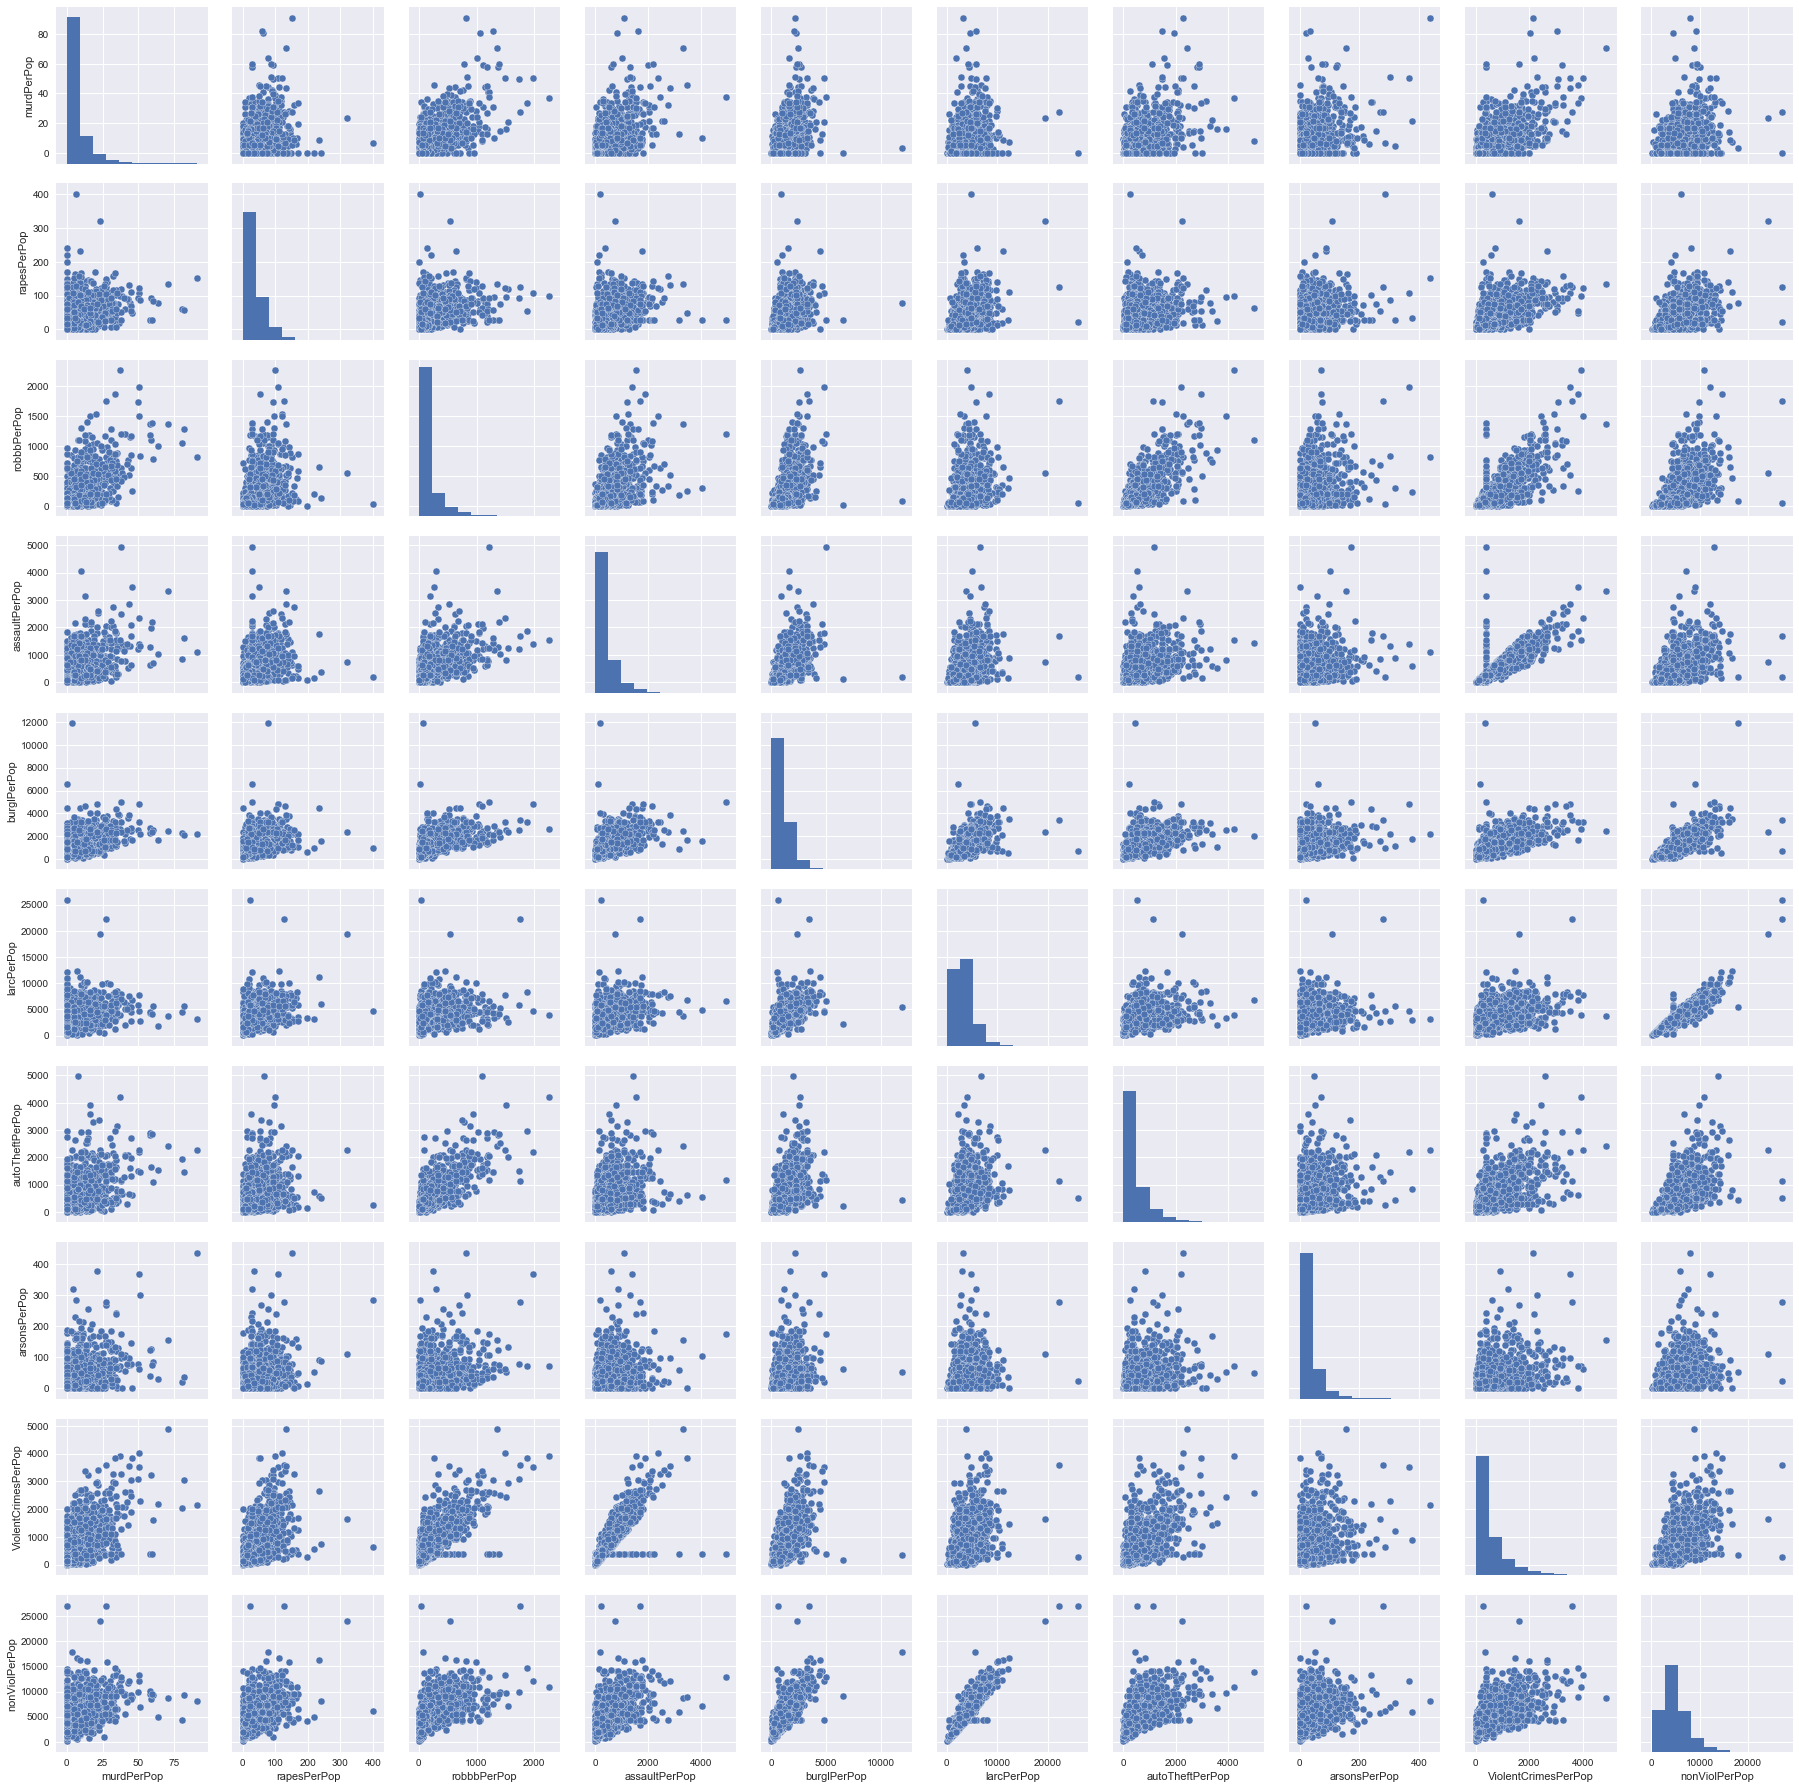

In [33]:
# Scatterplot Pair Matrix
sns.pairplot(crime_resp_df)
# Really want to standardize values though

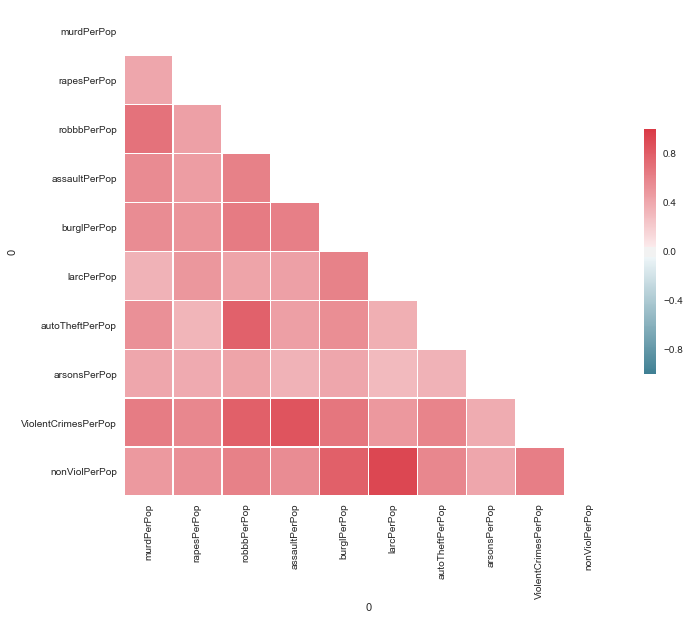

In [37]:
# Heat map to show correlations between response variables
sns.set(style="white")

# # Compute the correlation matrix
# for response variables
corr = crime_resp_df.corr()
# print(corr)
# # Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# print(mask)
# # Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [38]:
# We need to do scaling to ensure that 1 variable is not dominating the others
crime_resp_df

from sklearn.preprocessing import MinMaxScaler

cols = crime_resp_df.columns

scaler = MinMaxScaler(feature_range=(0,100))

response_scaled_df = pd.DataFrame(scaler.fit_transform(crime_resp_df),
                                 columns = cols)

In [39]:
response_scaled_df.describe()

,murdPerPop,rapesPerPop,robbbPerPop,assaultPerPop,burglPerPop,larcPerPop,autoTheftPerPop,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,6.432425,8.815634,7.180372,7.645526,8.565545,12.754079,9.415144,7.264188,11.638683,17.665869
std,10.052507,8.148849,10.354577,8.861700,6.430125,7.355247,10.164438,8.820229,12.032757,9.927954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.336240,1.221440,1.920933,4.174484,7.598434,3.033228,1.829869,3.799010,10.656143
50%,2.382259,6.707363,3.303697,4.592499,6.791876,11.619580,5.961359,4.830763,7.669785,15.956245
75%,9.183225,12.135293,8.265868,10.189863,11.225040,16.478404,11.742650,9.495382,14.804001,22.160822
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


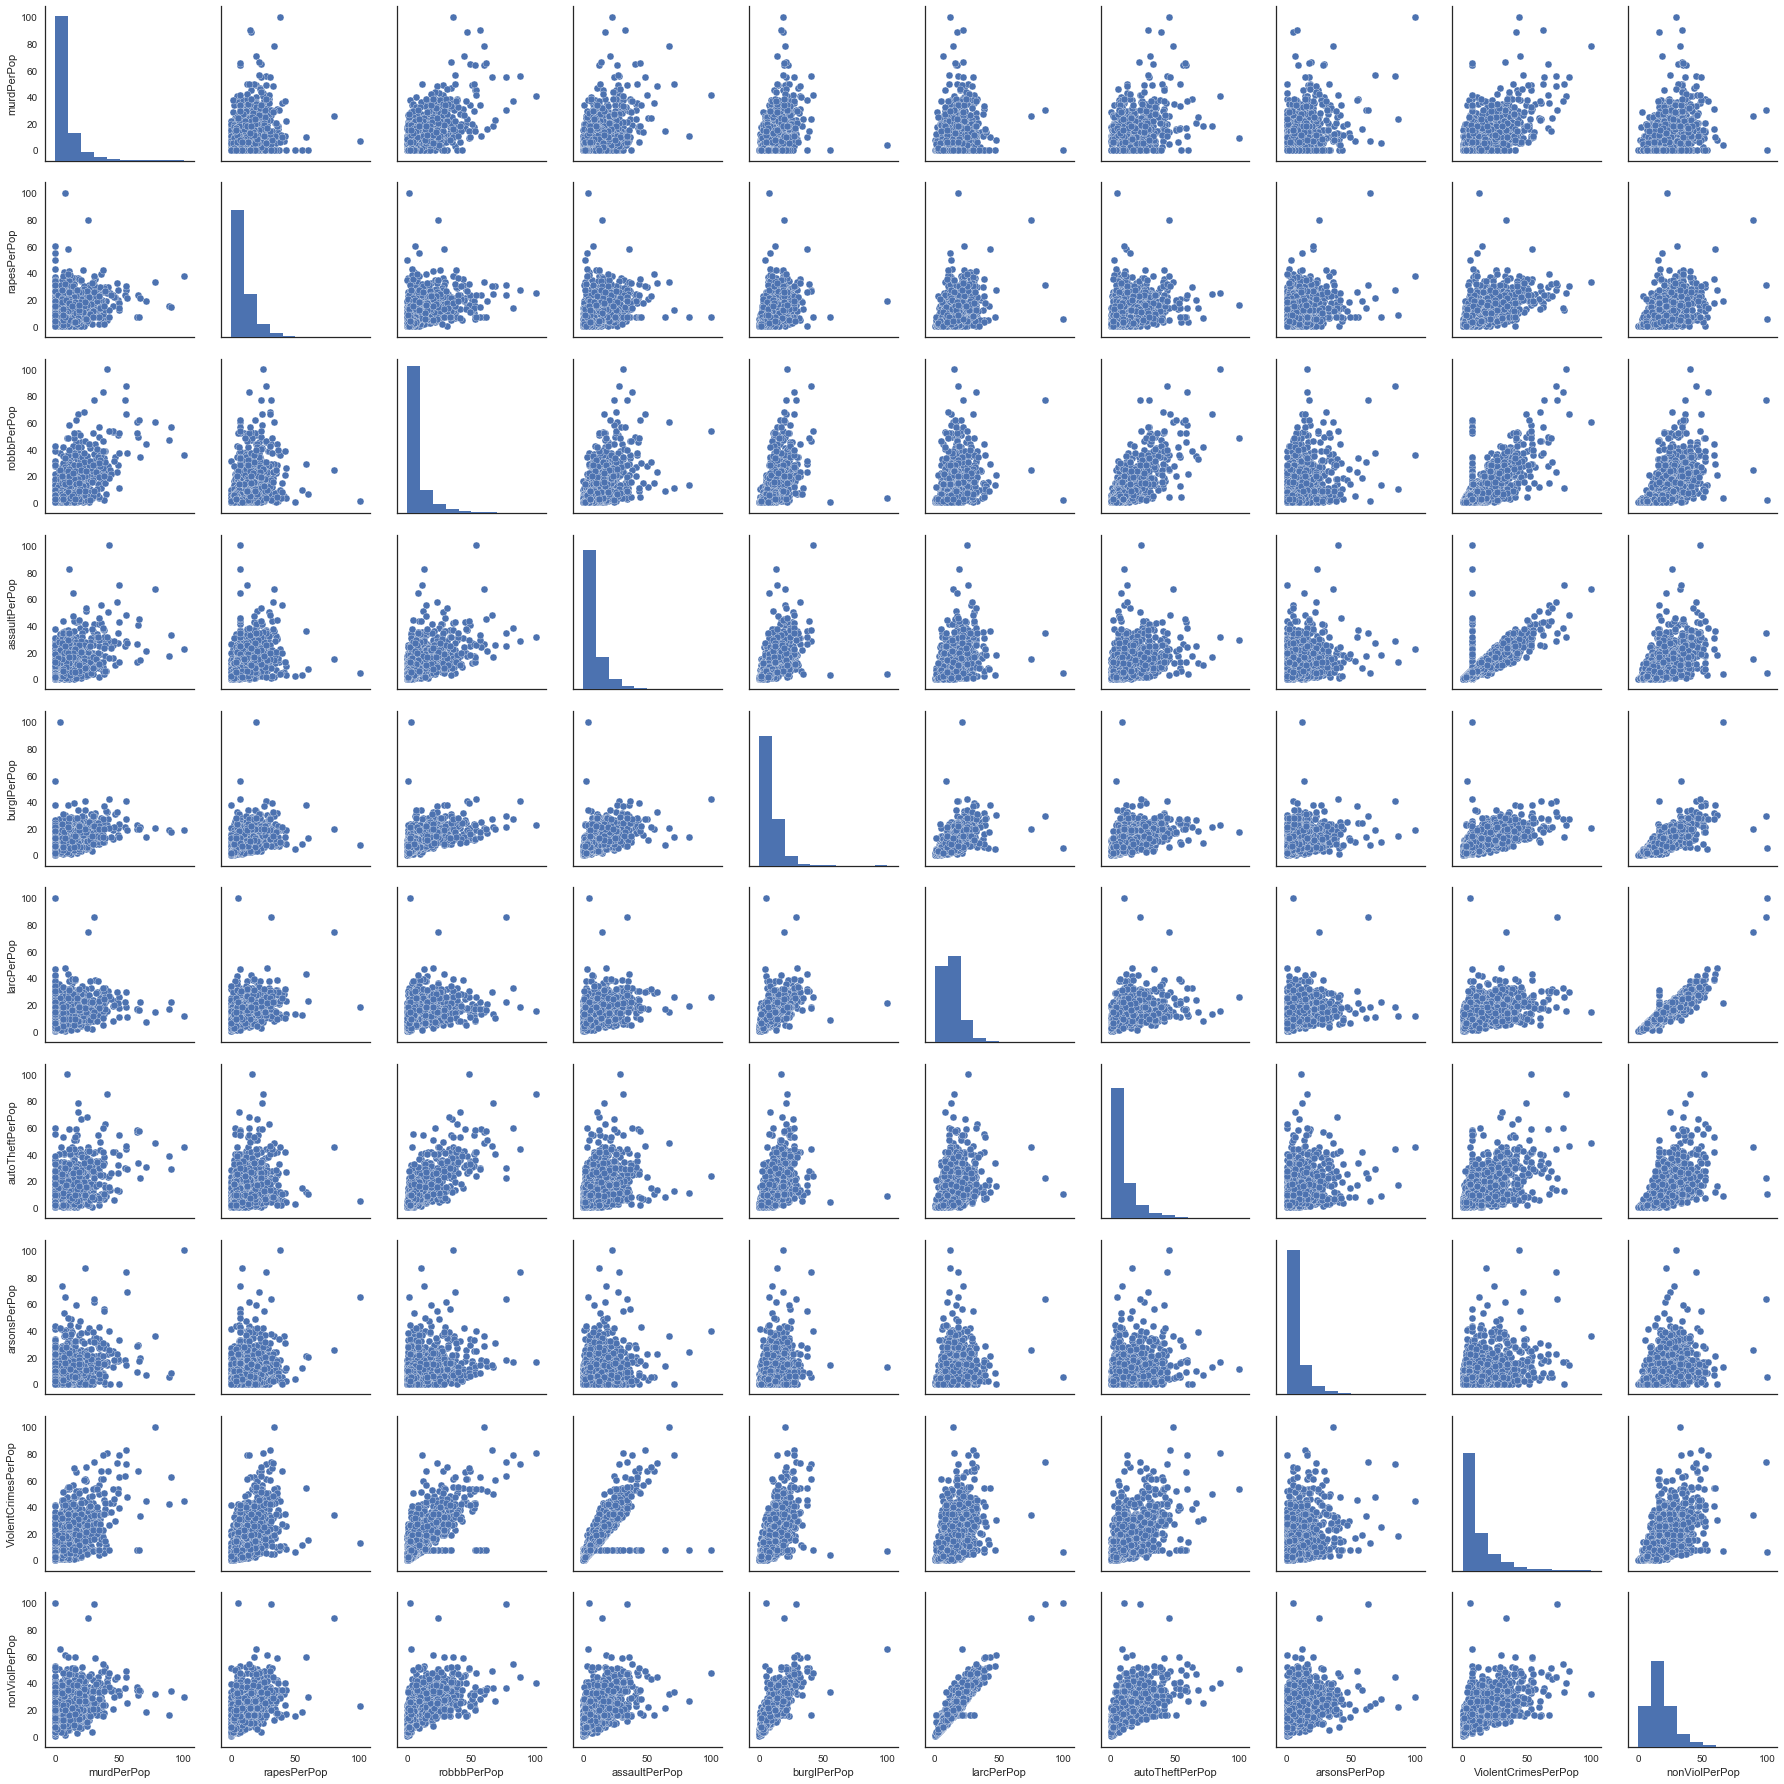

In [40]:
# Do the same pairplot but this time for the scaled responses
sns.pairplot(response_scaled_df)

In [41]:
# Get the predicted df
crime_pred_df = crime_df_clean.loc[:, :'LemasPctOfficDrugUn']
crime_pred_df.shape

(2215, 102)

In [42]:
# Pick the columns we need to scale
crime_pred_df.describe()
# Some of these are percentages; only need to scale the one with ranges 

preds2scale = crime_pred_df.columns[crime_pred_df.apply('max', axis = 0) > 1000]
print(preds2scale)
preds2notscale = crime_pred_df.columns[crime_pred_df.apply('max', axis = 0) < 1000]
print(preds2notscale)

Index([u'population', u'numbUrban', u'medIncome', u'medFamInc', u'perCapInc',
       u'whitePerCap', u'blackPerCap', u'indianPerCap', u'AsianPerCap',
       u'OtherPerCap', u'HispPerCap', u'NumUnderPov', u'NumKidsBornNeverMar',
       u'NumImmig', u'HousVacant', u'MedYrHousBuilt', u'OwnOccLowQuart',
       u'OwnOccMedVal', u'OwnOccHiQuart', u'OwnOccQrange', u'RentLowQ',
       u'RentMedian', u'RentHighQ', u'MedRent', u'NumInShelters', u'NumStreet',
       u'LandArea', u'PopDens'],
      dtype='object', name=0)
Index([u'householdsize', u'racepctblack', u'racePctWhite', u'racePctAsian',
       u'racePctHisp', u'agePct12t21', u'agePct12t29', u'agePct16t24',
       u'agePct65up', u'pctUrban', u'pctWWage', u'pctWFarmSelf', u'pctWInvInc',
       u'pctWSocSec', u'pctWPubAsst', u'pctWRetire', u'PctPopUnderPov',
       u'PctLess9thGrade', u'PctNotHSGrad', u'PctBSorMore', u'PctUnemployed',
       u'PctEmploy', u'PctEmplManu', u'PctEmplProfServ', u'PctOccupManu',
       u'PctOccupMgmtProf', u'Mal

In [43]:
# Acctually perform the scaling
scaled_df = pd.DataFrame(scaler.fit_transform(crime_pred_df[preds2scale]),
                        columns = preds2scale)

scaled_df.describe()

,population,numbUrban,medIncome,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,...,OwnOccHiQuart,OwnOccQrange,RentLowQ,RentMedian,RentHighQ,MedRent,NumInShelters,NumStreet,LandArea,PopDens
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,...,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,0.589575,0.651885,21.888215,22.876343,17.853310,17.507177,5.441142,2.547748,13.401770,6.892115,...,24.823656,17.106482,25.606052,35.021254,42.155412,38.252950,0.286334,0.170609,0.743085,6.272821
std,2.798203,2.807851,11.698150,11.085170,10.818150,10.014264,4.352302,3.094549,9.307461,5.784468,...,20.989975,11.814652,15.979874,19.376464,24.333429,20.923577,2.413091,2.349503,3.077211,6.397557
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.059637,0.000000,13.028172,14.849760,10.962714,11.263372,3.178625,1.321875,7.804361,4.035401,...,9.771069,9.728097,12.694013,19.239501,22.466422,21.260816,0.000000,0.000000,0.179327,2.650164
50%,0.174864,0.246375,19.671660,20.403544,15.265651,15.148790,4.609183,2.061458,11.538643,5.975182,...,16.638371,13.111782,23.059867,31.441544,37.118437,33.992583,0.000000,0.000000,0.358654,4.561973
75%,0.451538,0.572450,28.419993,28.431639,21.627486,20.728802,6.848011,3.074479,16.321292,8.412409,...,33.870212,19.773414,35.698448,48.127128,58.302808,52.286774,0.094085,0.009572,0.706100,7.489162
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [44]:
# And combine with the unscaled columns
pred_scaled_df = pd.concat([scaled_df, crime_pred_df[preds2notscale]], axis=1)

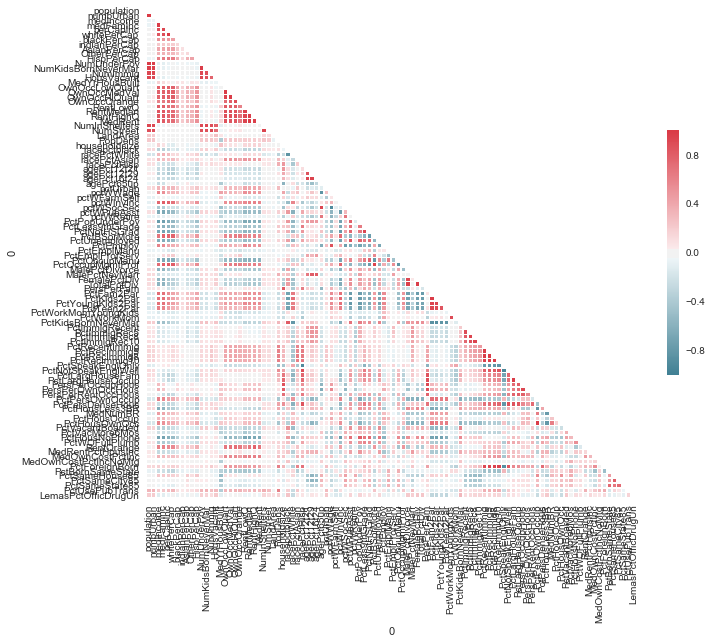

In [45]:
# Heatmap for predictors too
sns.set(style="white")

# # Compute the correlation matrix
# for response variables
corr = pred_scaled_df.corr()
# print(corr)
# # Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# print(mask)
# # Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


### In-Class Exercise 4 - Principal Component Analysis on the Response Variables

- Obtain the principal components for the response variables
- Plot the loadings on the first two principal components
- Plot the observations in the first two principal components
- Overlay towns with more than one murder on the first two principal components

### In-Class Exercise 4 - Principal Component Analysis on the Response Variables Answers

- Obtain the principal components for the response variables done below
- Plot the loadings on the first two principal components done below
- Plot the observations in the first two principal components done below
- Overlay towns with more than one murder on the first two principal components done below

In [46]:
############
## perform PCA on the response variables

n = len(response_scaled_df.columns)

pca = PCA(n_components = n)
# default is the number of columns in the data 
# but can be set to any integer less than or equal to that value

crimes_response_pca = pca.fit_transform(response_scaled_df)

# Percentage of variance explained by the first two components

percent_explained = pca.explained_variance_ratio_[:2].sum()*100

print('Percent of explained variance (first two components): %0.0f'
      % percent_explained)


crimes_response_pca.shape


Percent of explained variance (first two components): 71


(2215, 10)

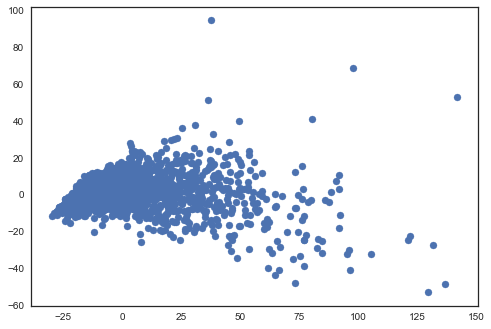

In [47]:
# # PCA scatter plot of the first two principal components

plt.scatter(crimes_response_pca[:,0],crimes_response_pca[:,1])

In [71]:
# Towns/communities with > 0 reported murders.

murder_towns = crime_df_clean.murdPerPop > 0


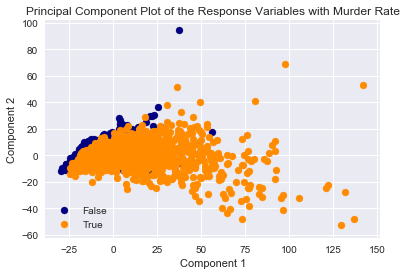

In [87]:
# PCA plot with labels for murder towns
colors = ['navy', 'darkorange']

fig, ax = plt.subplots()
for i, color in  zip([False, True], colors):
        ax.scatter(crimes_response_pca[murder_towns == i, 0],
                   crimes_response_pca[murder_towns == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the Response Variables with Murder Rate')


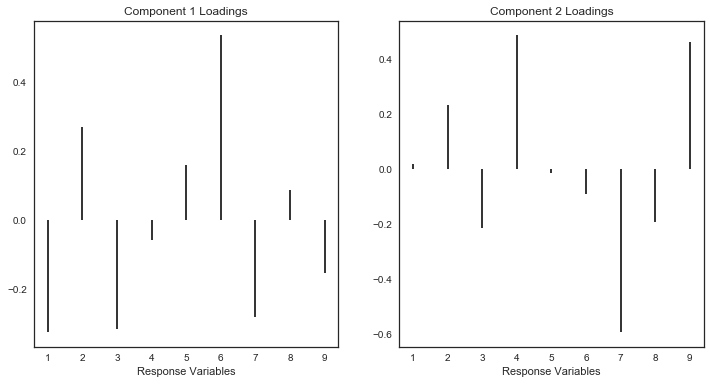

In [48]:
# PCA loadings
# Response Variables PCA

fig = plt.figure(figsize=(12, 6))
Comp1 = fig.add_subplot(121)
Comp2 = fig.add_subplot(122)

Comp1.vlines(range(1,len(crime_resp_df.columns)), [0],pca.components_[1,:])
Comp1.set_xlabel('Response Variables')
Comp1.set_title('Component 1 Loadings')

Comp2.vlines(range(1,len(crime_resp_df.columns)), [0],pca.components_[2,:])
Comp2.set_xlabel('Response Variables')
Comp2.set_title('Component 2 Loadings')


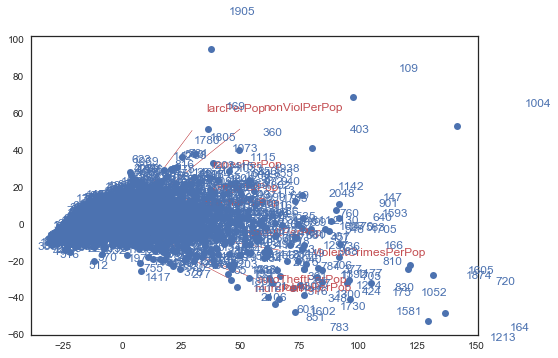

In [53]:
# # The biplot like the one in R
# # This will take a while to run

# It's trying to give us some idea of 

# ## project data into PC space
# first 2 PC

pca = PCA(n_components=2)
crimes_response_pca = pca.fit_transform(response_scaled_df)
# # 0,1 denote PC1 and PC2; change values for other PCs
xvector = pca.components_[0] # see 'prcomp(my_data)$rotation' in R
yvector = pca.components_[1]

xs = crimes_response_pca[:,0] # see 'prcomp(my_data)$x' in R
ys = crimes_response_pca[:,1]

for i in range(len(xvector)):
# arrows project features (ie columns from csv) as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(response_scaled_df.columns.values)[i], color='r')

for i in range(len(xs)):
# circles project observations (ie rows from csv) as points onto PC axes
    plt.plot(xs[i], ys[i], 'bo')
    plt.text(xs[i]*1.2, ys[i]*1.2,
             list(response_scaled_df.index)[i], color='b')



### In-Class Exercise 5 - Principal Component Analysis on the Predictor Variables

- Obtain the principal components for the predictor variables
- Plot the loadings on the first two principal components
- Plot the observations in the first two principal components
- Overlay towns with more than one murder on the first two principal components
- Overlay the violent crime rate binned using the box plot statistics
- Overlay the non-violent crime rate binned using the box plot statistics
- Overlay at least one other crime rate binned using the box plot statistics

Here are is an example:

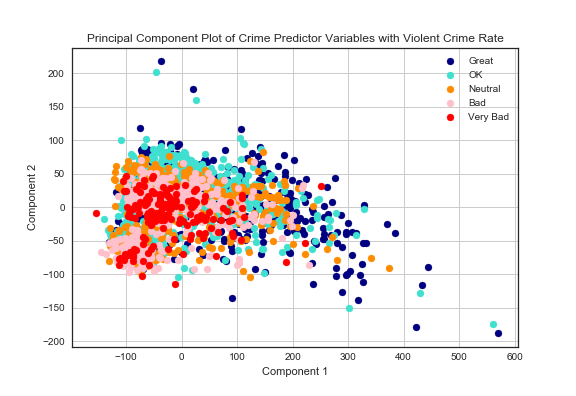


### In-Class Exercise 5 - Principal Component Analysis on the Predictor Variables Answers

- Obtain the principal components for the predictor variables is done below
- Plot the loadings on the first two principal components is done below
- Plot the observations in the first two principal components is done below
- Overlay towns with more than one murder on the first two principal components is done below
- Overlay the violent crime rate binned using the box plot statistics is done below
- Overlay the non-violent crime rate binned using the box plot statistics is done below
- Overlay at least one other crime rate binned using the box plot statistics is done below for rape

In [54]:
############
## perform PCA on the predictor variables

n = len(pred_scaled_df.columns)

pca = PCA(n_components = n)
# default is the number of columns in the data 
# but can be set to any integer less than or equal to that value

crimes_predictor_pca = pca.fit_transform(pred_scaled_df)

# Percentage of variance explained by the first two components

percent_explained = pca.explained_variance_ratio_[:2].sum()*100

print('Percent of explained variance (first two components): %0.0f'
      % percent_explained)


crimes_predictor_pca.shape


Percent of explained variance (first two components): 64


(2215, 102)

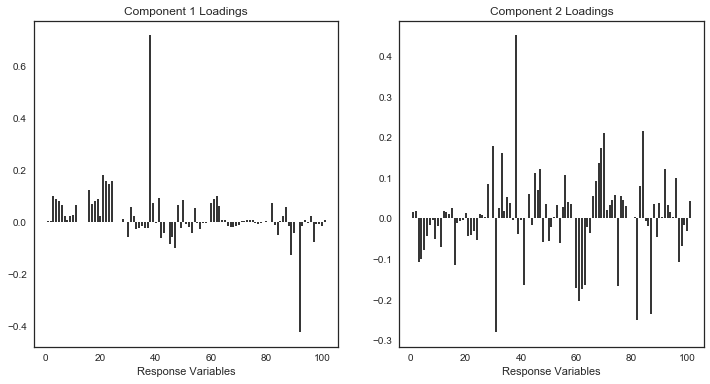

In [55]:
# PCA loadings
# Response Variables PCA

fig = plt.figure(figsize=(12, 6))
Comp1 = fig.add_subplot(121)
Comp2 = fig.add_subplot(122)

Comp1.vlines(range(1,len(crime_pred_df.columns)), [0],pca.components_[1,:])
Comp1.set_xlabel('Response Variables')
Comp1.set_title('Component 1 Loadings')

Comp2.vlines(range(1,len(crime_pred_df.columns)), [0],pca.components_[2,:])
Comp2.set_xlabel('Response Variables')
Comp2.set_title('Component 2 Loadings')


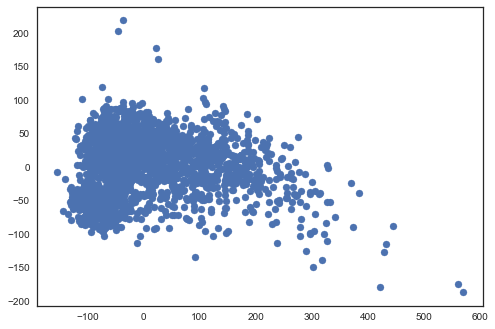

In [56]:
# # PCA scatter plot of the first two principal components

plt.scatter(crimes_predictor_pca[:,0],crimes_predictor_pca[:,1])

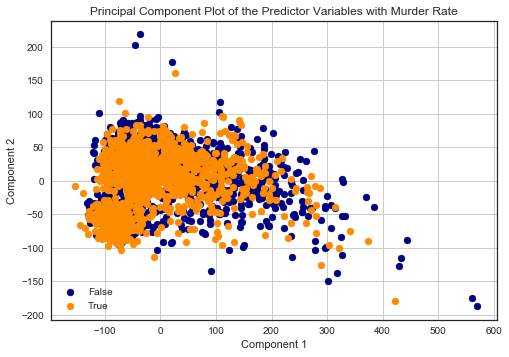

In [59]:
# PCA plot with labels for murder towns
colors = ['navy', 'darkorange']

fig, ax = plt.subplots()
for i, color in  zip([False, True], colors):
        ax.scatter(crimes_predictor_pca[murder_towns == i, 0],
                   crimes_predictor_pca[murder_towns == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the Predictor Variables with Murder Rate')


[0.0, 185.28, 374.06, 722.0, 1523.9200000000001]


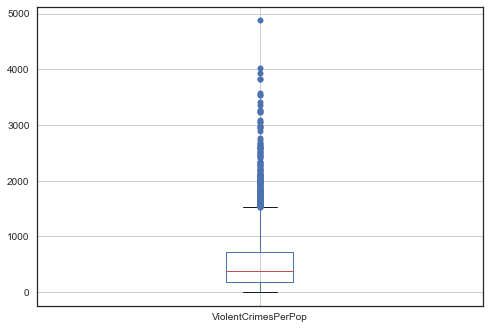

In [93]:
# Doing the first two PC scatterplots with ViolentCrimesPerPop as the binned response
violent_box = crime_resp_df.boxplot(column = 'ViolentCrimesPerPop',
                                   return_type = 'dict', sym = 'b')

violent_box_bounds = [violent_box['whiskers'][0].get_ydata()[1], # lower whisker
                    violent_box['boxes'][0].get_ydata()[0],      # lower box 25%
                    violent_box['medians'][0].get_ydata()[0],    # median
                    violent_box['boxes'][0].get_ydata()[2],      # upper box 75%
                    violent_box['whiskers'][1].get_ydata()[1]]   # upper whisker

print(violent_box_bounds)

In [94]:
# Now need to make a new column to correctly take care 
# of each of these boundary points and label our data by violent crime rates
crime_levels = ['Great', 'Okay', 'Neutral', 'Bad', 'Abyssmal']

# And now bin the data
bins = violent_box_bounds
bins.append(crime_resp_df['ViolentCrimesPerPop'].max())

In [95]:
# Now use pd.cut to break the Violent Crimes into the different labels that we created above based on their bins
Violent = pd.cut(crime_resp_df['ViolentCrimesPerPop'], bins, labels = crime_levels)

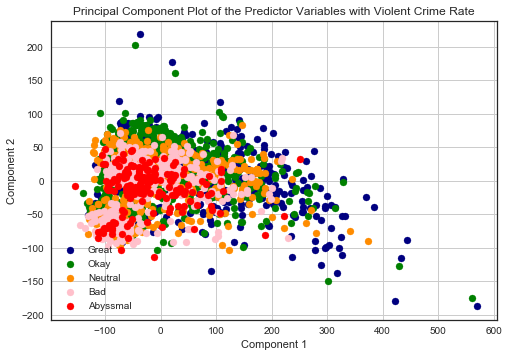

In [96]:
# PCA plot with labels for Violent Crime levels
colors = ['navy', 'green', 'darkorange', 'pink', 'red']

fig, ax = plt.subplots()
for i, color in  zip(crime_levels, colors):
        ax.scatter(crimes_predictor_pca[Violent == i, 0],
                   crimes_predictor_pca[Violent == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the Predictor Variables with Violent Crime Rate')


[116.79000000000001, 2994.2650000000003, 4425.4500000000007, 6100.8699999999999, 10739.530000000001]


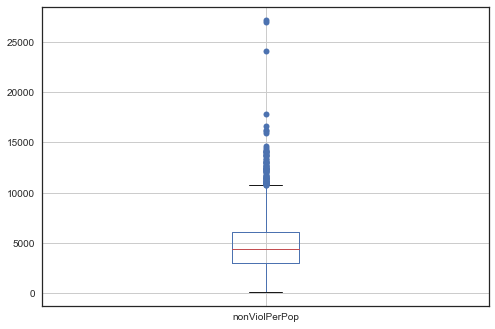

In [97]:
# Doing the first two PC scatterplots with nonViolPerPop as the binned response
nonviolent_box = crime_resp_df.boxplot(column = 'nonViolPerPop',
                                   return_type = 'dict', sym = 'b')

nonviolent_box_bounds = [nonviolent_box['whiskers'][0].get_ydata()[1], # lower whisker
                    nonviolent_box['boxes'][0].get_ydata()[0],      # lower box 25%
                    nonviolent_box['medians'][0].get_ydata()[0],    # median
                    nonviolent_box['boxes'][0].get_ydata()[2],      # upper box 75%
                    nonviolent_box['whiskers'][1].get_ydata()[1]]   # upper whisker

print(nonviolent_box_bounds)

In [98]:
# Now need to make a new column to correctly take care 
# of each of these boundary points and label our data by nonviolent crime rates
crime_levels = ['Great', 'Okay', 'Neutral', 'Bad', 'Abyssmal']

# And now bin the data
bins = nonviolent_box_bounds
bins.append(crime_resp_df['nonViolPerPop'].max())

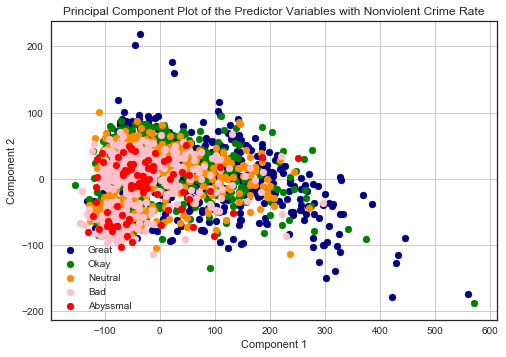

In [99]:
# Now use pd.cut to break the NonViolent Crimes into the different labels that we created above based on their bins
NonViolent = pd.cut(crime_resp_df['nonViolPerPop'], bins, labels = crime_levels)

# PCA plot with labels for NonViolent Crime levels
colors = ['navy', 'green', 'darkorange', 'pink', 'red']

fig, ax = plt.subplots()
for i, color in  zip(crime_levels, colors):
        ax.scatter(crimes_predictor_pca[NonViolent == i, 0],
                   crimes_predictor_pca[NonViolent == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the Predictor Variables with Nonviolent Crime Rate')

[0.0, 13.390000000000001, 26.920000000000002, 48.704999999999998, 101.66]


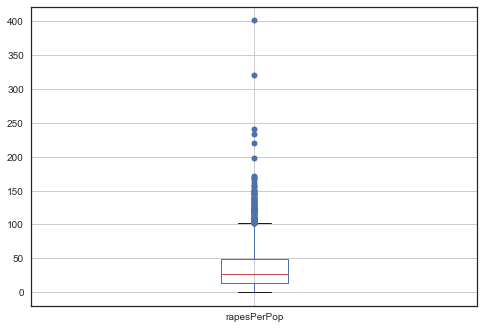

In [100]:
# Doing the first two PC scatterplots with nonViolPerPop as the binned response
rapes_box = crime_resp_df.boxplot(column = 'rapesPerPop',
                                   return_type = 'dict', sym = 'b')

rapes_box_bounds = [rapes_box['whiskers'][0].get_ydata()[1], # lower whisker
                    rapes_box['boxes'][0].get_ydata()[0],      # lower box 25%
                    rapes_box['medians'][0].get_ydata()[0],    # median
                    rapes_box['boxes'][0].get_ydata()[2],      # upper box 75%
                    rapes_box['whiskers'][1].get_ydata()[1]]   # upper whisker

print(rapes_box_bounds)


# Produce all of these with a log transformation

In [101]:
# Now need to make a new column to correctly take care 
# of each of these boundary points and label our data by rape rates
crime_levels = ['Great', 'Okay', 'Neutral', 'Bad', 'Abyssmal']

# And now bin the data
bins = rapes_box_bounds
bins.append(crime_resp_df['rapesPerPop'].max())

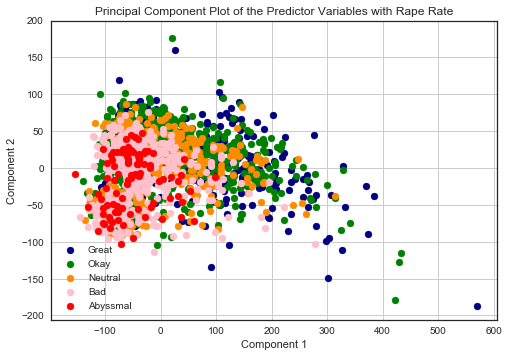

In [102]:
# Now use pd.cut to break the Rape Crimes into the different labels that we created above based on their bins
Rapes = pd.cut(crime_resp_df['rapesPerPop'], bins, labels = crime_levels)

# PCA plot with labels for Rape Crime levels
colors = ['navy', 'green', 'darkorange', 'pink', 'red']

fig, ax = plt.subplots()
for i, color in  zip(crime_levels, colors):
        ax.scatter(crimes_predictor_pca[Rapes == i, 0],
                   crimes_predictor_pca[Rapes == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the Predictor Variables with Rape Rate')


### In-Class Exercise 6 - Principal Component Analysis on the Log Transformation of the Predictor Variables

- Obtain the principal components for the log transformation of the predictor variables
- Plot the loadings on the first two principal components
- Plot the observations in the first two principal components
- Overlay towns with more than one murder on the first two principal components
- Overlay the violent crime rate binned using the box plot statistics
- Overlay the non-violent crime rate binned using the box plot statistics
- Overlay at least one other crime rate binned using the box plot statistics

Here are is an example:

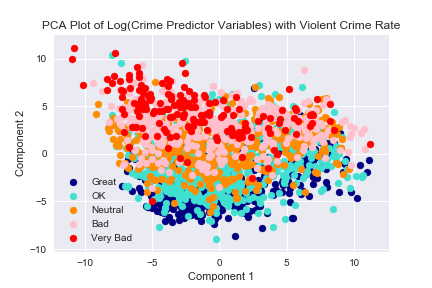

### In-Class Exercise 6 - Principal Component Analysis on the Log Transformation of the Predictor Variables Answers

- Obtain the principal components for the log transformation of the predictor variables done below
- Plot the loadings on the first two principal components done below
- Plot the observations in the first two principal components done below
- Overlay towns with more than one murder on the first two principal components done below
- Overlay the violent crime rate binned using the box plot statistics done below
- Overlay the non-violent crime rate binned using the box plot statistics done below
- Overlay at least one other crime rate binned using the box plot statistics done below for rape

In [118]:
# Take the log transform of the predictor space
pred_log_scaled_df = np.log(pred_scaled_df + .1)

In [119]:
############
## perform PCA on the predictor variables

n = len(pred_log_scaled_df.columns)

pca = PCA(n_components = n)
# default is the number of columns in the data 
# but can be set to any integer less than or equal to that value

crimes_predictor_log_pca = pca.fit_transform(pred_log_scaled_df)

# Percentage of variance explained by the first two components

percent_explained = pca.explained_variance_ratio_[:2].sum()*100

print('Percent of explained variance (first two components): %0.0f'
      % percent_explained)


crimes_predictor_log_pca.shape


Percent of explained variance (first two components): 48


(2215, 102)

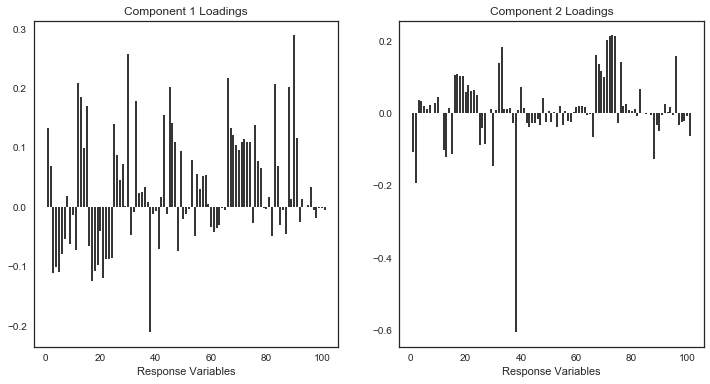

In [120]:
# PCA loadings
# Response Variables PCA

fig = plt.figure(figsize=(12, 6))
Comp1 = fig.add_subplot(121)
Comp2 = fig.add_subplot(122)

Comp1.vlines(range(1,len(crime_pred_df.columns)), [0],pca.components_[1,:])
Comp1.set_xlabel('Response Variables')
Comp1.set_title('Component 1 Loadings')

Comp2.vlines(range(1,len(crime_pred_df.columns)), [0],pca.components_[2,:])
Comp2.set_xlabel('Response Variables')
Comp2.set_title('Component 2 Loadings')


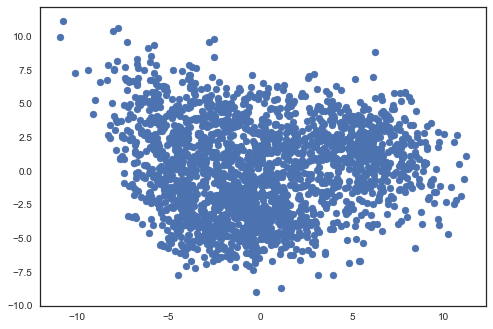

In [121]:
# # PCA scatter plot of the first two principal components

plt.scatter(crimes_predictor_log_pca[:,0],crimes_predictor_log_pca[:,1])

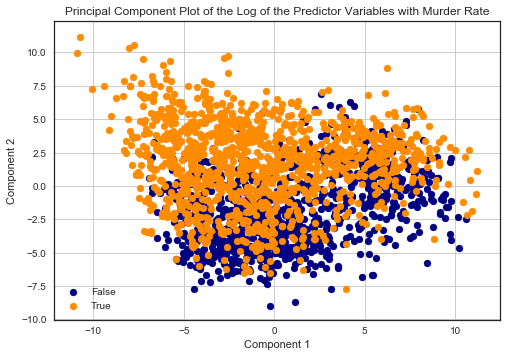

In [122]:
# PCA plot with labels for murder towns
colors = ['navy', 'darkorange']

fig, ax = plt.subplots()
for i, color in  zip([False, True], colors):
        ax.scatter(crimes_predictor_log_pca[murder_towns == i, 0],
                   crimes_predictor_log_pca[murder_towns == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the Log of the Predictor Variables with Murder Rate')


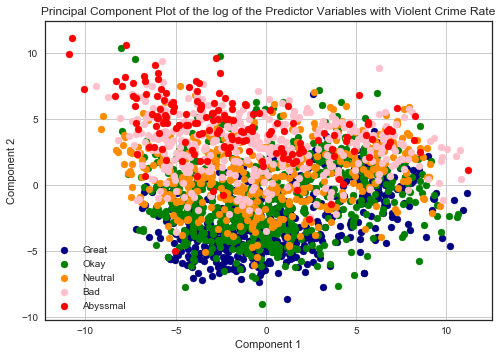

In [123]:
# PCA log plot with labels for Violent Crime levels
colors = ['navy', 'green', 'darkorange', 'pink', 'red']

fig, ax = plt.subplots()
for i, color in  zip(crime_levels, colors):
        ax.scatter(crimes_predictor_log_pca[Violent == i, 0],
                   crimes_predictor_log_pca[Violent == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the log of the Predictor Variables with Violent Crime Rate')


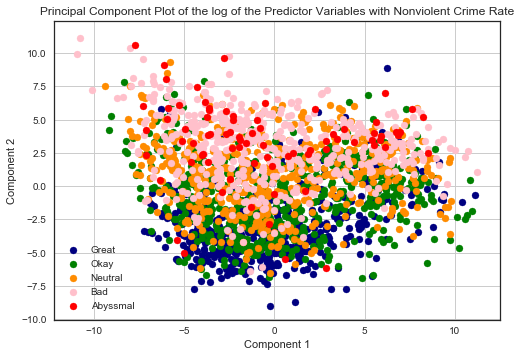

In [124]:
# PCA log plot with labels for NonViolent Crime levels
colors = ['navy', 'green', 'darkorange', 'pink', 'red']

fig, ax = plt.subplots()
for i, color in  zip(crime_levels, colors):
        ax.scatter(crimes_predictor_log_pca[NonViolent == i, 0],
                   crimes_predictor_log_pca[NonViolent == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the log of the Predictor Variables with Nonviolent Crime Rate')


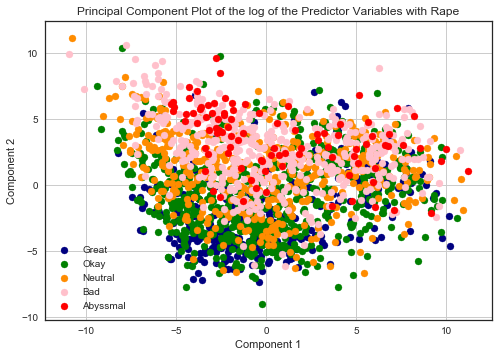

In [126]:
# PCA log plot with labels for Rape Crime levels
colors = ['navy', 'green', 'darkorange', 'pink', 'red']

fig, ax = plt.subplots()
for i, color in  zip(crime_levels, colors):
        ax.scatter(crimes_predictor_log_pca[Rapes == i, 0],
                   crimes_predictor_log_pca[Rapes == i, 1], c = color, label=i)


ax.legend(loc = 3)
ax.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Principal Component Plot of the log of the Predictor Variables with Rape')
